In [1]:
from rdflib import Graph
import sys
g_train = Graph()
g_val = Graph()

g_train = g_train.parse('FB15k-237/train.nt', format='nt')
g_val   = g_val.parse('FB15k-237/valid.nt', format='nt')
import torch

In [2]:
import sys
sys.path.append('../code')

from settings import VECTOR_SIZE,BERT_MAXLEN,BERT_EPOCHS
from utils_data import DataseSimpleTriple
torch.set_num_threads(12)

###
from torch.utils.data import Dataset, DataLoader



###

#### Use objectives from T5 https://arxiv.org/abs/1910.10683

Also look at Bert paper: https://arxiv.org/abs/1810.04805

First is 'Bert Style' masked language modeling. (MLM)

* Corrupt 15% of input tokens. 
* 90% of the corrupted tokens are replaced with out-of-alphabet masking token
* 10% of corrupted tokens are replaced with random tokens

#### Other Sources

* https://towardsdatascience.com/how-to-train-a-bert-model-from-scratch-72cfce554fc6 as example of Bert training
* https://huggingface.co/blog/how-to-train
* tiny bert https://arxiv.org/abs/2110.01518

#### Notes

* Bert: "In contrast to denoising auto-encoders (Vincent et al., 2008), we only predict the masked words rather than reconstructing the entire input."
* Which tokenizer?! BPE useful? I think not. Look at https://huggingface.co/docs/transformers/main/en/tokenizer_summary

## Construct Dataset of 'Sentences'

In [3]:
import torch
import numpy as np

In [4]:
# Just use each triple as a sentence ...
dataset_most_simple = [' '.join(x) for x in g_train]
dataset_most_simple_eval = [' '.join(x) for x in g_val]

In [5]:
dataset_most_simple[0:10]

['http://example.org/m/071t0 http://example.org/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country http://example.org/m/0697s',
 'http://example.org/m/09c7w0 http://example.org/location/location/contains http://example.org/m/01hjy5',
 'http://example.org/m/0bbm7r http://example.org/tv/tv_program/regular_cast./tv/regular_tv_appearance/actor http://example.org/m/016ywr',
 'http://example.org/m/0257w4 http://example.org/award/award_category/winners./award/award_honor/award_winner http://example.org/m/03_0p',
 'http://example.org/m/03hr1p http://example.org/olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country http://example.org/m/0jgd',
 'http://example.org/m/06449 http://example.org/award/award_winner/awards_won./award/award_honor/award_winner http://example.org/m/0280mv7',
 'http://example.org/m/01f5q5 http://example.org/award/award_nominee/award_nominations./award/award_nomination/award http://example.org/m/07cbcy',
 'http://example.or

# Define and Train Tokenizer
It is unclear which tokenizer works. I will start with a really simple example.

In [6]:
import transformers

2023-03-05 20:33:45.045070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-05 20:33:45.045087: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
from tokenizers.models import WordLevel
from tokenizers import Tokenizer
from transformers import BertTokenizer, EncoderDecoderModel, BertForTokenClassification
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer
from tokenizers.processors import BertProcessing
from transformers import BertConfig, BertModel, AutoModel
import copy
from collections import defaultdict
import torchmetrics

from tqdm import tqdm, trange

In [8]:
tz = BertTokenizer.from_pretrained("bert-base-cased")
special_tokens_map = tz.special_tokens_map_extended
special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [9]:
from torch.utils.data import Dataset, DataLoader



In [10]:
dataset_simple = DataseSimpleTriple(dataset_most_simple,special_tokens_map)
dataset_simple_eval = DataseSimpleTriple(dataset_most_simple_eval,special_tokens_map)
tz = dataset_simple.get_tokenizer()




In [11]:
dataset_simple[0]

(tensor([[   3,    0],
         [ 594,    0],
         [  48,    0],
         [3864,    0],
         [   1,    0]]),
 tensor([1., 1., 1., 1., 1.]),
 tensor([   3,  594,   48, 3864,    1]))

# Setup Model

In [12]:
tiny_pretrained = AutoModel.from_pretrained('prajjwal1/bert-tiny')
tiny_config = tiny_pretrained.config
tiny_config._name_or_path="otautz/tiny"

encoder_config = copy.copy(tiny_config)
encoder_config.is_decoder = False
encoder_config.add_cross_attention = False
encoder_config.num_labels=tz.get_vocab_size()
encoder_config.hidden_size = VECTOR_SIZE
encoder_config.max_position_embeddings = BERT_MAXLEN
del tiny_pretrained

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tiny_encoder  = BertForTokenClassification(encoder_config)
tiny_encoder  = tiny_encoder.to(device)
lossF = torch.nn.CrossEntropyLoss()
dl = DataLoader(dataset_simple,batch_size=5000,shuffle=True,pin_memory=True)
dl_eval =  DataLoader(dataset_simple_eval, batch_size=5000, shuffle=False, pin_memory=True)
optimizer = torch.optim.Adam(tiny_encoder.parameters())

In [14]:
loss_metric = torchmetrics.aggregation.MeanMetric().to(device)
batchloss_metric = torchmetrics.aggregation.CatMetric().to(device)
batchloss_metric_eval = torchmetrics.aggregation.CatMetric().to(device)
history = defaultdict(list)

#for ep in trange(BERT_EPOCHS):
for epochs in trange(5):
    for inputs, batch_mask, batch_labels in dl:
        tiny_encoder.train()
        optimizer.zero_grad()
        batch_id = inputs[:,:,0]
        
        out = tiny_encoder.forward(batch_id.to(device), batch_mask.to(device))
        logits = out.logits

        # (batchsize, sequence_len, no_labels)
        logits_shape = logits.shape

        # (batchsize * sequence_len, no_labels)
        logits_no_sequence =  logits.reshape(logits_shape[0]*logits_shape[1],logits_shape[2])

        # (batchsize)
        batch_labels_no_sequence = batch_labels.flatten().to(device)
        
        batch_mask = (inputs[:,:,1]>0).flatten().to(device)

        loss= lossF(logits_no_sequence[batch_mask],batch_labels_no_sequence[batch_mask])

        loss.backward()
        optimizer.step()
        
        loss_metric(loss.detach())
        batchloss_metric(loss.detach())
    
    history['loss'].append(loss_metric.compute().detach().item())
    loss_metric.reset()
    with torch.no_grad():
        tiny_encoder.eval()
        for inputs, batch_mask, batch_labels in dl_eval:
                        optimizer.zero_grad()
                        batch_id = inputs[:, :, 0]

                        out = tiny_encoder.forward(batch_id.to(device), batch_mask.to(device))
                        logits = out.logits

                        # (batchsize, sequence_len, no_labels)
                        logits_shape = logits.shape

                        # (batchsize * sequence_len, no_labels)
                        logits_no_sequence = logits.reshape(logits_shape[0] * logits_shape[1], logits_shape[2])

                        # (batchsize)
                        batch_labels_no_sequence = batch_labels.flatten().to(device)

                        batch_mask = (inputs[:, :, 1] > 0).flatten().to(device)

                        loss = lossF(logits_no_sequence[batch_mask], batch_labels_no_sequence[batch_mask])

                        loss_metric(loss.detach())
                        batchloss_metric_eval(loss.detach())

        history['loss_eval'].append(loss_metric.compute().detach().item())
        loss_metric.reset()    
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [31:03<00:00, 372.76s/it]


<AxesSubplot:>

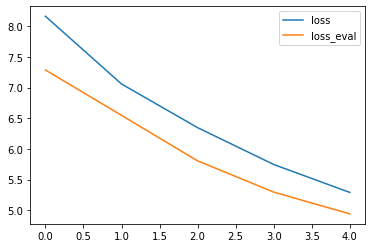

In [15]:
import pandas as pd
pd.DataFrame(history).to_csv('bert_loss_eval.csv')
pl = pd.DataFrame(history).plot()
pl.figure.savefig('loss_eval_loss.pdf')

<AxesSubplot:>

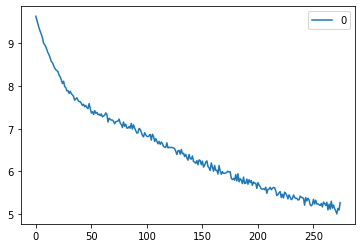

In [16]:
pd.DataFrame(batchloss_metric.compute().detach().cpu()).to_csv('bert_batchloss.csv')
pl = pd.DataFrame(batchloss_metric.compute().detach().cpu()).plot()
pl.figure.savefig('batchloss.pdf')

<AxesSubplot:>

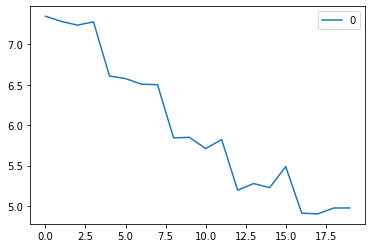

In [17]:
pd.DataFrame(batchloss_metric_eval.compute().detach().cpu()).to_csv('bert_batchloss_eval.csv')
pl = pd.DataFrame(batchloss_metric_eval.compute().detach().cpu()).plot()
pl.figure.savefig('batchloss_eval.pdf')
# # Save pretrained

In [18]:
tiny_encoder.save_pretrained("tiny_bert_from_scratch_simple_eval")
tz.save('tiny_bert_from_scratch_simple_tokenizer_eval.json')

# Test Loading

In [19]:
model = AutoModel.from_pretrained('tiny_bert_from_scratch_simple_eval')
tz = Tokenizer(WordLevel(unk_token=special_tokens_map['unk_token']))

Some weights of the model checkpoint at tiny_bert_from_scratch_simple_eval were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at tiny_bert_from_scratch_simple_eval and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import PreTrainedTokenizerFast

In [21]:
tz = PreTrainedTokenizerFast(tokenizer_file='tiny_bert_from_scratch_simple_tokenizer_eval.json')

In [22]:
test = dataset_most_simple[0]
test = tz.encode(test)

In [23]:
torch.tensor(test)

tensor([   3,  594,   48, 3864,    1])

In [24]:
model(torch.tensor(test).unsqueeze(0))['last_hidden_state'].squeeze().shape

torch.Size([5, 128])

In [25]:
from utils_graph import get_entities

In [26]:
def get_embeddings(entities,bert_model,tokenizer):
    entities = [tokenizer.encode(x) for x in np.array(entities)]
    embeddings = model(torch.tensor(entities))
    embeddings = embeddings['last_hidden_state'][:,1]
    return embeddings

In [27]:
entities = get_entities([g_train])

In [28]:
embs = get_embeddings(entities,model,tz)

In [29]:
embs.shape

torch.Size([14505, 128])